## SENG 474 - Assignment 3
### Chris Wong - V00780634

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import random
import sys
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import MinMaxScaler 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df1 = pd.read_csv('dataset1.csv', names=['X','Y'], header=None)
df2 = pd.read_csv('dataset2.csv', names=['X','Y', 'Z'], header=None)
dataset1 = df1.to_numpy()
dataset2 = df2.to_numpy()

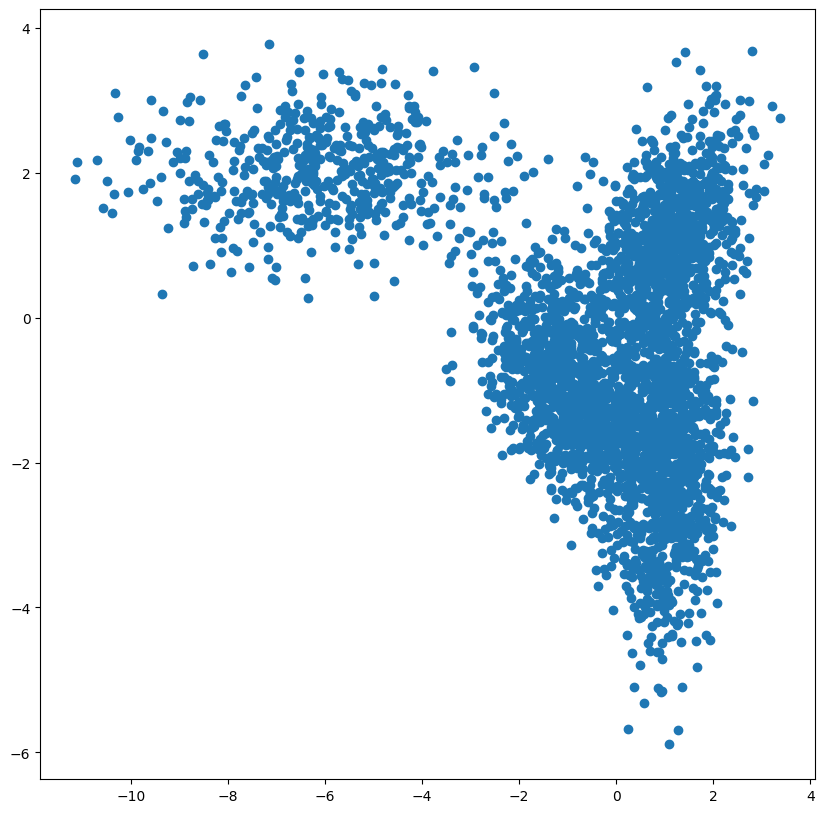

In [3]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.scatter(df1['X'], df1['Y'])
plt.show()

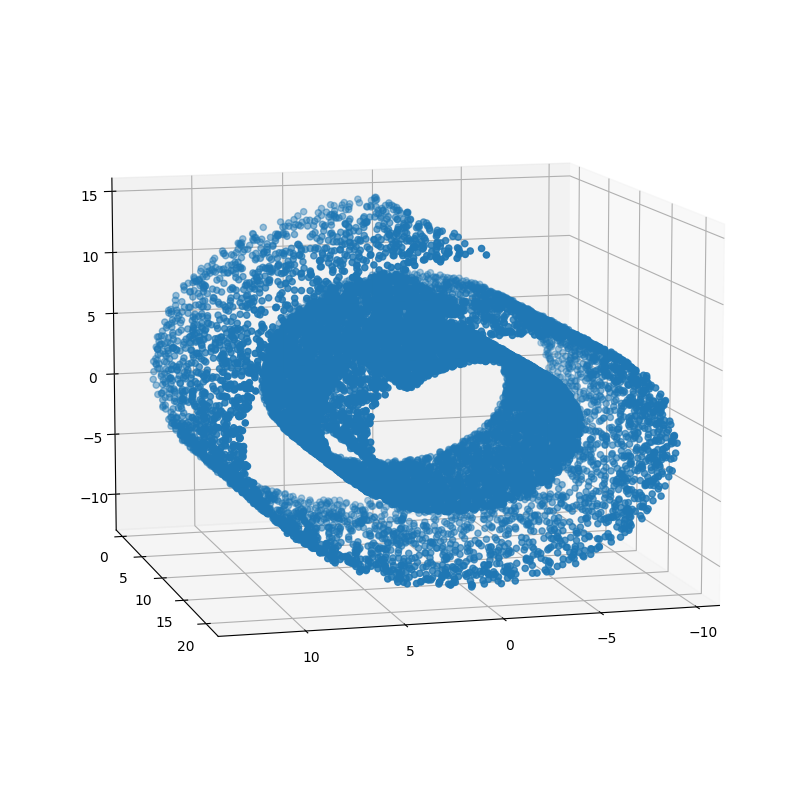

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(df2['X'], df2['Y'], df2['Z'])
ax.view_init(10, 75)
plt.show()

### Lloyd's Algorithm

In [5]:
# Assign points to clusters based on distance
def assign_points(points, centers):
    clusters = {}
    for index, center in enumerate(centers):
        clusters[index] = []
    for point_index, point in enumerate(points):
        distances = []
        for center in centers:
            dist = np.linalg.norm(point - center)
            distances.append(dist)
        dist, center_index = min((dist, idx) for (idx, dist) in enumerate(distances))
        clusters[center_index].append(point_index)
    return clusters
    
# Recalculate Position of cluster Center
def recalculate_centers_2D(clusters, centers, points):
    # Move cluster centers
    for center in clusters:
        cluster_size = len(clusters[center])
        sum_x = 0
        sum_y = 0
        for point_index in clusters[center]:
            sum_x += points[point_index][0]
            sum_y += points[point_index][1]
        if cluster_size > 0:    
            centers[center][0] = sum_x/cluster_size
            centers[center][1] = sum_y/cluster_size
    return

def recalculate_centers_3D(clusters, centers, points):
    # Move cluster centers
    for center in clusters:
        cluster_size = len(clusters[center])
        sum_x = 0
        sum_y = 0
        sum_z = 0
        for point_index in clusters[center]:
            sum_x += points[point_index][0]
            sum_y += points[point_index][1]
            sum_z += points[point_index][2]
        centers[center][0] = sum_x/cluster_size
        centers[center][1] = sum_y/cluster_size
        centers[center][2] = sum_z/cluster_size
    return

# Return the sum of all squared Euclidean distances to their respective centers
def calculate_cost(clusters, centers, points):
    total_cost = 0
    for center in clusters:
        for point in clusters[center]:
            total_cost += np.linalg.norm(points[point] - centers[center])**2
    return total_cost

# Perform Lloyd's Algorithm
def lloyd(points, centers, is_2D):
    old_clusters = {}
    for index, center in enumerate(centers):
        old_clusters[index] = []
    while True:
        clusters = assign_points(points, centers)
        if is_2D:
            recalculate_centers_2D(clusters, centers, points)
        else:
            recalculate_centers_3D(clusters, centers, points)
        for center in clusters:
            if clusters[center] != old_clusters[center]:
                total_cost = calculate_cost(clusters, centers, points)
                return (clusters, total_cost)
        old_clusters = clusters.copy()
    return


### K-Means++ Initialization

In [6]:
# Calculate centers for K-Means++
def k_plus_plus(initial_center, points, k, is_2D):
    centers = initial_center
    for i in range(k - 1):
        candidate_points = []
        dist = []
        clusters = assign_points(points, centers)
        for center, point_list in clusters.items():
            for point in point_list:
                # Add points and distances to lists
                if points[point] not in centers:
                    dist.append(np.linalg.norm(points[point] - centers)**2)
                    candidate_points.append(points[point])
        # Draw a singles point from the candidate_points list with
        # with probability weighted based on distances
        next_center = random.choices(candidate_points, weights = dist, k=1) 
        if is_2D:
            centers = np.append(centers, next_center[0].reshape(1,2), axis = 0)
        else:
            centers = np.append(centers, next_center[0].reshape(1,3), axis = 0)
    return centers

### Dataset 1

In [7]:
uniform_random_centers_list_2d  = []
uniform_random_clusters_list_2d = []
uniform_random_cost_list_2d     = []
k_plus_plus_centers_list_2d     = []
k_plus_plus_clusters_list_2d    = []
k_plus_plus_cost_list_2d        = []
k_list_2d                       = []
                
for K in range(2, 12):
    best_uniform_random_centers = []
    best_uniform_random_clusters = {}
    best_uniform_random_cost = sys.float_info.max
    best_k_plis_plus_centers = []
    best_k_plus_plus_clusters = {}
    best_k_plus_plus_cost = sys.float_info.max
    
    # Perform tests 50 times and take best outcome
    for i in range(50):
        # Take uniform sample from Dataset 1
        uniform_centers_2D = df1.sample(n = K).to_numpy()

        # Take random initial center for K-Means++
        initial_center_2D = df1.sample(n = 1).to_numpy()

        # Initialize with K-means++
        k_plus_plus_centers_2D = k_plus_plus(initial_center_2D, dataset1, K, True)

        # Run Lloyd's Algorithm
        uniform_random_2D_clusters, uniform_random_2D_cost = lloyd(dataset1, uniform_centers_2D, True)
        k_plus_plus_2D_clusters, k_plus_plus_2D_cost = lloyd(dataset1, k_plus_plus_centers_2D, True)
        
        if uniform_random_2D_cost < best_uniform_random_cost:
            best_uniform_random_centers = uniform_centers_2D
            best_uniform_random_clusters = uniform_random_2D_clusters
            best_uniform_random_cost = uniform_random_2D_cost
        if k_plus_plus_2D_cost < best_k_plus_plus_cost:
            best_k_plis_plus_centers = k_plus_plus_centers_2D
            best_k_plus_plus_clusters = k_plus_plus_2D_clusters
            best_k_plus_plus_cost = k_plus_plus_2D_cost
    
    uniform_random_centers_list_2d.append(best_uniform_random_centers)
    uniform_random_clusters_list_2d.append(best_uniform_random_clusters)
    uniform_random_cost_list_2d.append(best_uniform_random_cost)
    k_plus_plus_centers_list_2d.append(best_k_plis_plus_centers)
    k_plus_plus_clusters_list_2d.append(best_k_plus_plus_clusters)
    k_plus_plus_cost_list_2d.append(best_k_plus_plus_cost)
    k_list_2d.append(K)

### Dataset 2

In [8]:
uniform_random_centers_list_3d  = []
uniform_random_clusters_list_3d = []
uniform_random_cost_list_3d     = []
k_plus_plus_centers_list_3d     = []
k_plus_plus_clusters_list_3d    = []
k_plus_plus_cost_list_3d        = []
k_list_3d                       = []

for K in range(2, 12):
    best_uniform_random_centers = []
    best_uniform_random_clusters = {}
    best_uniform_random_cost = sys.float_info.max
    best_k_plis_plus_centers = []
    best_k_plus_plus_clusters = {}
    best_k_plus_plus_cost = sys.float_info.max

    # Perform tests 50 times and take best outcome
    for i in range(50):
        uniform_centers_3D = df2.sample(n = K).to_numpy()

        # Take random initial center for K-Means++
        initial_center_3D = df2.sample(n = 1).to_numpy()
        k_plus_plus_centers_3D = k_plus_plus(initial_center_3D, dataset2, K, False)

        # Run Lloyd's Algorithm
        uniform_random_3D_clusters, uniform_random_3D_cost = lloyd(dataset2, uniform_centers_3D, False)
        k_plus_plus_3D_clusters, k_plus_plus_3D_cost = lloyd(dataset2, k_plus_plus_centers_3D, False)
        
        if uniform_random_3D_cost < best_uniform_random_cost:
            best_uniform_random_centers = uniform_centers_3D
            best_uniform_random_clusters = uniform_random_3D_clusters
            best_uniform_random_cost = uniform_random_3D_cost
        if k_plus_plus_3D_cost < best_k_plus_plus_cost:
            best_k_plis_plus_centers = k_plus_plus_centers_3D
            best_k_plus_plus_clusters = k_plus_plus_3D_clusters
            best_k_plus_plus_cost = k_plus_plus_3D_cost

    uniform_random_centers_list_3d.append(best_uniform_random_centers)
    uniform_random_clusters_list_3d.append(best_uniform_random_clusters)
    uniform_random_cost_list_3d.append(best_uniform_random_cost)
    k_plus_plus_centers_list_3d.append(best_k_plis_plus_centers)
    k_plus_plus_clusters_list_3d.append(best_k_plus_plus_clusters)
    k_plus_plus_cost_list_3d.append(best_k_plus_plus_cost)
    k_list_3d.append(K)

### Cost Plot

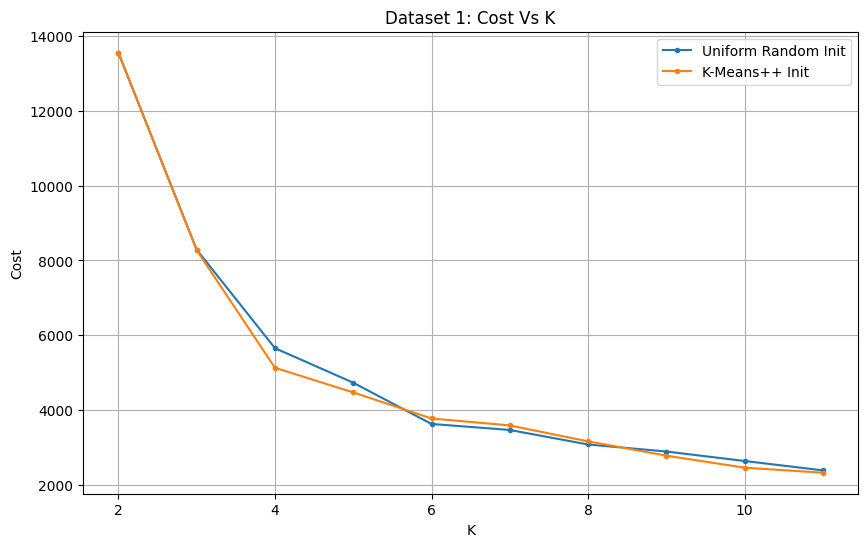

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('K')
ax.set_ylabel('Cost')
ax.set_title('Dataset 1: Cost Vs K')
ax.plot(k_list_2d, uniform_random_cost_list_2d, marker='.', label='Uniform Random Init')
ax.plot(k_list_2d, k_plus_plus_cost_list_2d, marker='.', label='K-Means++ Init')
ax.grid('True')
ax.legend()

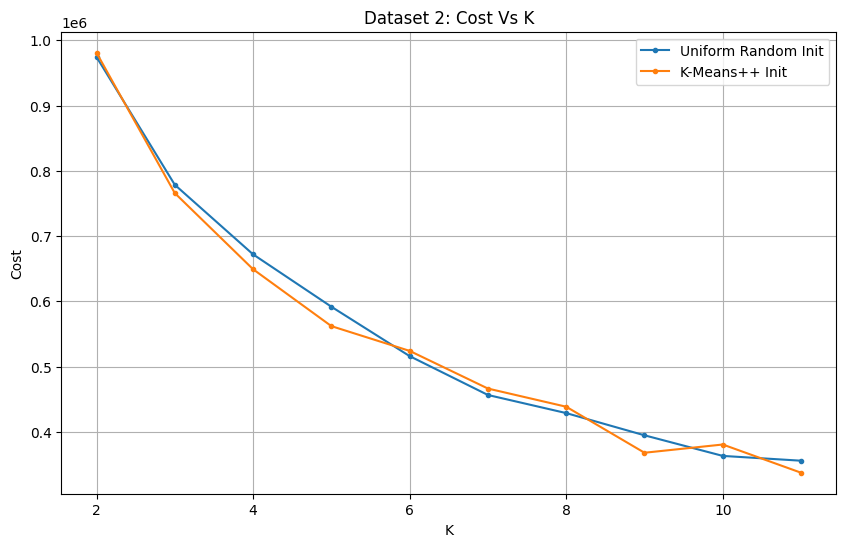

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('K')
ax.set_ylabel('Cost')
ax.set_title('Dataset 2: Cost Vs K')
ax.plot(k_list_3d, uniform_random_cost_list_3d, marker='.', label='Uniform Random Init')
ax.plot(k_list_3d, k_plus_plus_cost_list_3d, marker='.', label='K-Means++ Init')
ax.grid('True')
ax.legend()

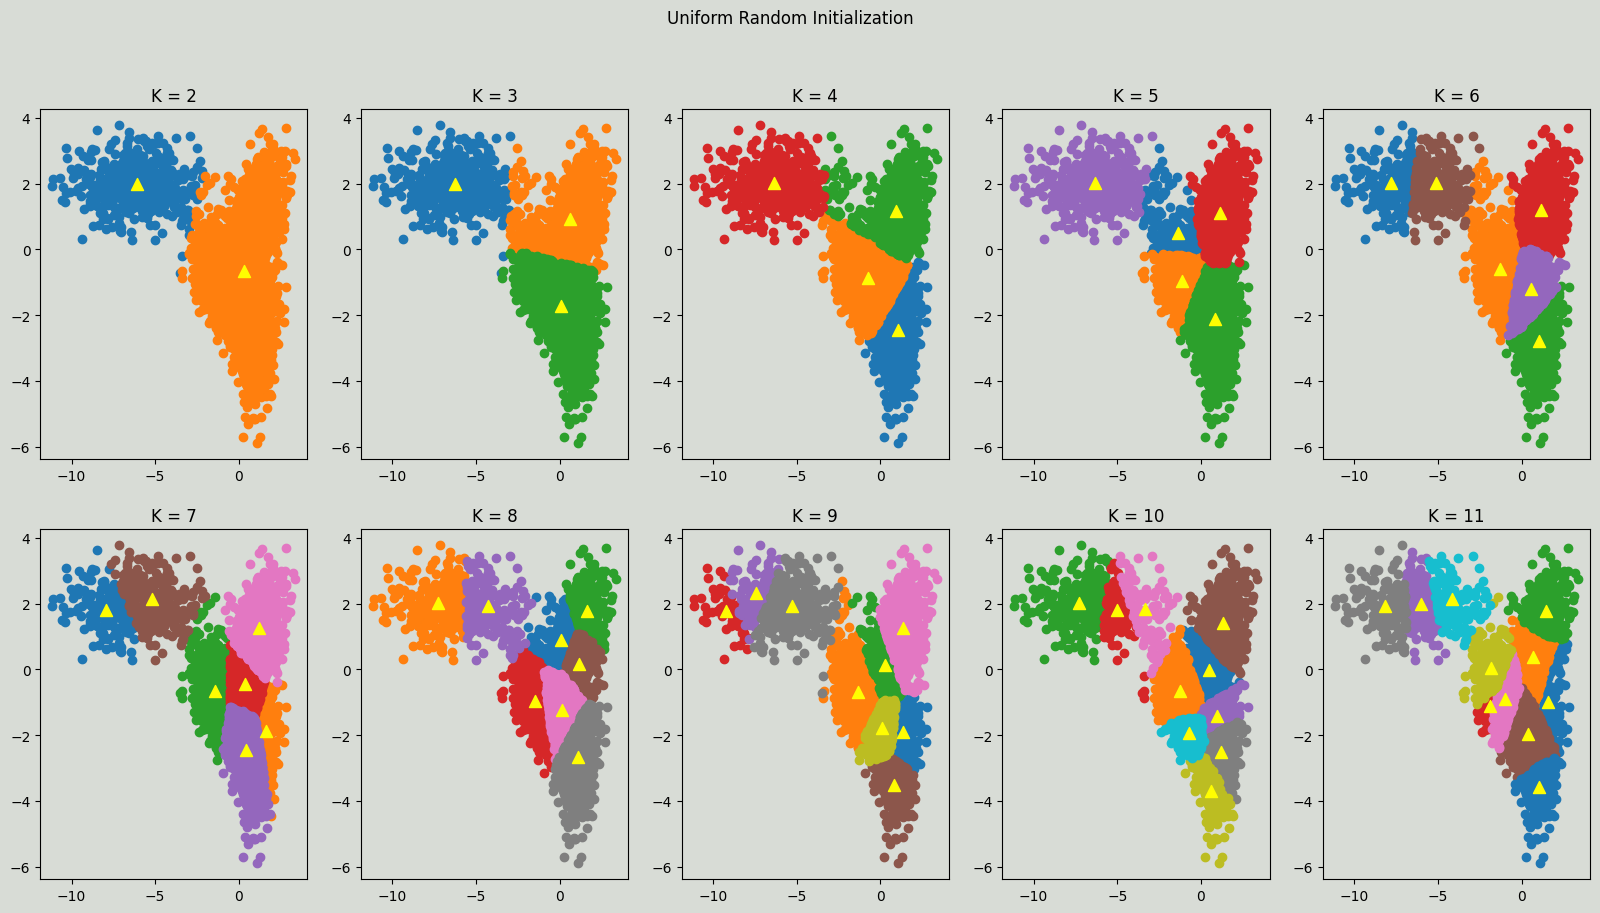

In [11]:
fig = plt.figure(figsize=(20, 10))
fig.set_facecolor('xkcd:light grey')

for i in range(1, 11):
    plt.subplot(2, 5, i, facecolor='xkcd:light grey')
    title = 'K = ' + str(i + 1)
    plt.title(title)
    for center in uniform_random_clusters_list_2d[i-1]:
        point_set_x = []
        point_set_y = []
        for point in uniform_random_clusters_list_2d[i-1][center]:
            point_set_x.append(dataset1[point][0])
            point_set_y.append(dataset1[point][1])
        plt.scatter(point_set_x, point_set_y, zorder=1)
    plt.scatter(uniform_random_centers_list_2d[i-1].T[0], uniform_random_centers_list_2d[i-1].T[1], marker='^', zorder = 2, s=75, color='xkcd:bright yellow')
plt.suptitle('Uniform Random Initialization')
plt.show()

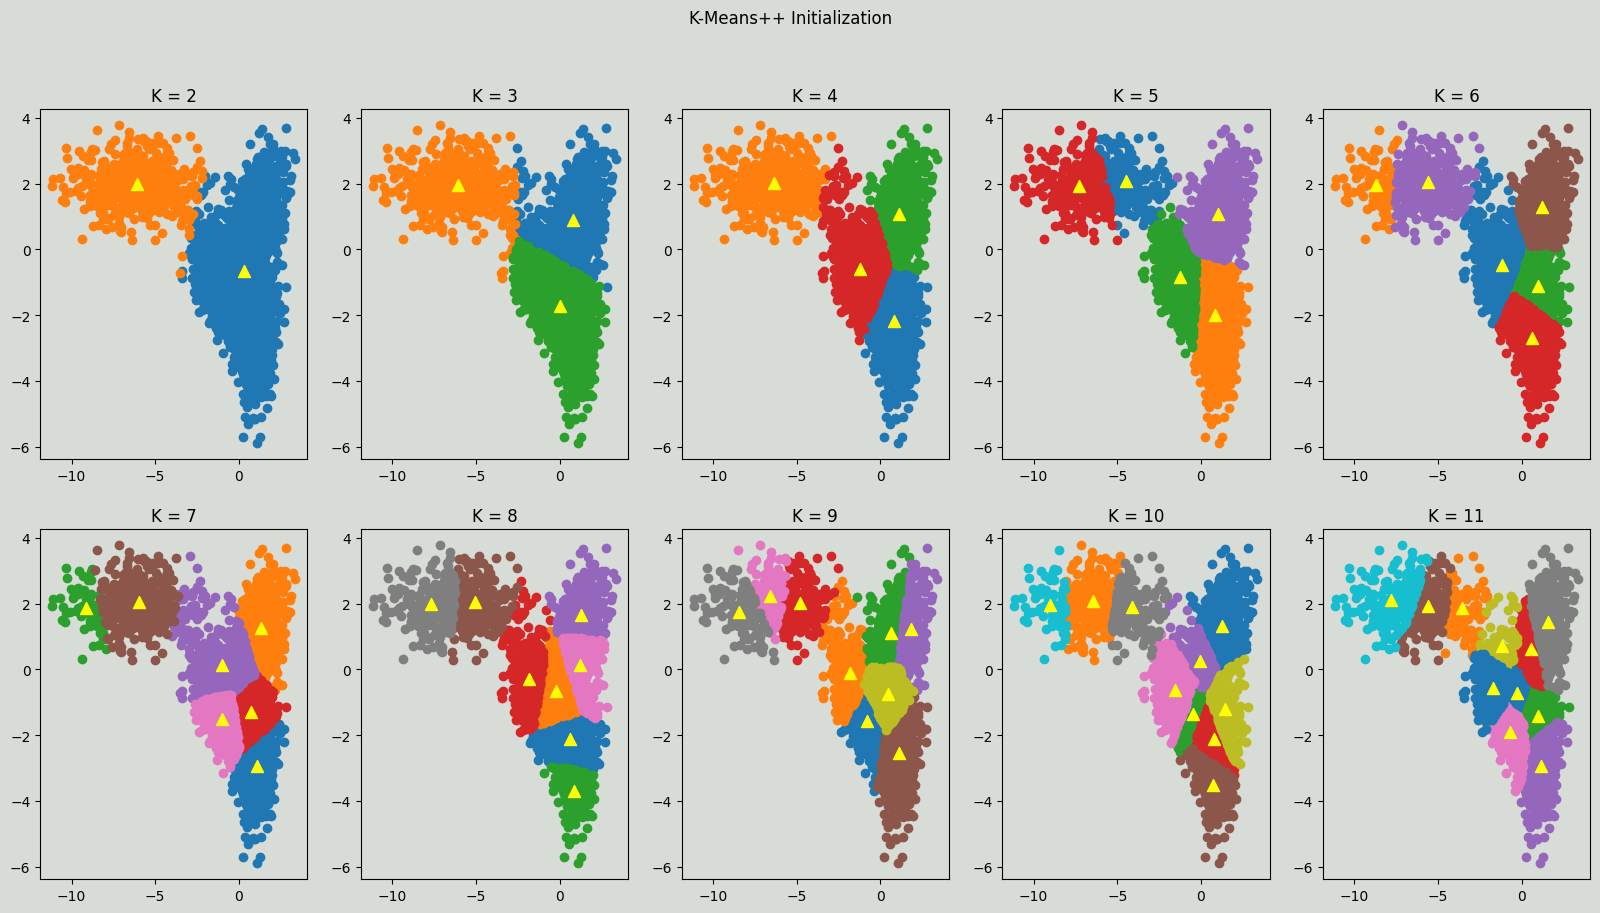

In [12]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('xkcd:light grey')

for i in range(1, 11):
    plt.subplot(2, 5, i, facecolor='xkcd:light grey')
    title = 'K = ' + str(i + 1)
    plt.title(title)
    for center in k_plus_plus_clusters_list_2d[i-1]:
        point_set_x = []
        point_set_y = []
        for point in k_plus_plus_clusters_list_2d[i-1][center]:
            point_set_x.append(dataset1[point][0])
            point_set_y.append(dataset1[point][1])
        plt.scatter(point_set_x, point_set_y, zorder=1)
    plt.scatter(k_plus_plus_centers_list_2d[i-1].T[0], k_plus_plus_centers_list_2d[i-1].T[1], marker='^', zorder = 2, s=75, color='xkcd:bright yellow')
plt.suptitle('K-Means++ Initialization')
plt.show()

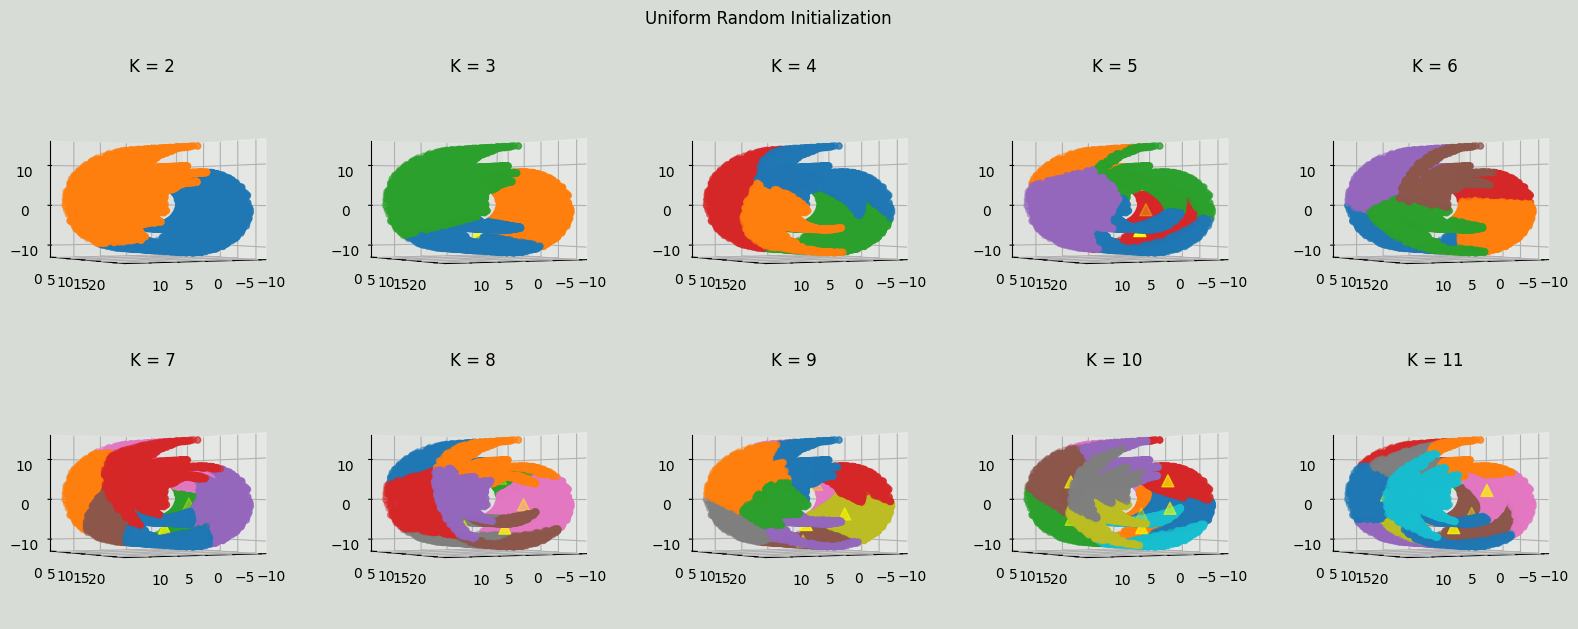

In [13]:
fig = plt.figure(figsize=(20,7))
fig.set_facecolor('xkcd:light grey')

for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i, projection='3d')
    ax.set_facecolor('xkcd:light grey')
    title = 'K = ' + str(i + 1)
    ax.title.set_text(title)
    for center in uniform_random_clusters_list_3d[i-1]:
        point_set_x_3D = []
        point_set_y_3D = []
        point_set_z_3D = []
        for point in uniform_random_clusters_list_3d[i-1][center]:
            point_set_x_3D.append(dataset2[point][0])
            point_set_y_3D.append(dataset2[point][1])
            point_set_z_3D.append(dataset2[point][2])
        ax.scatter(point_set_x_3D, point_set_y_3D, point_set_z_3D)
    ax.scatter(uniform_random_centers_list_3d[i-1].T[0], uniform_random_centers_list_3d[i-1].T[1], uniform_random_centers_list_3d[i-1].T[2], marker='^', s=75, color='xkcd:bright yellow')
    ax.view_init(0, 60)
plt.suptitle('Uniform Random Initialization')
plt.show()

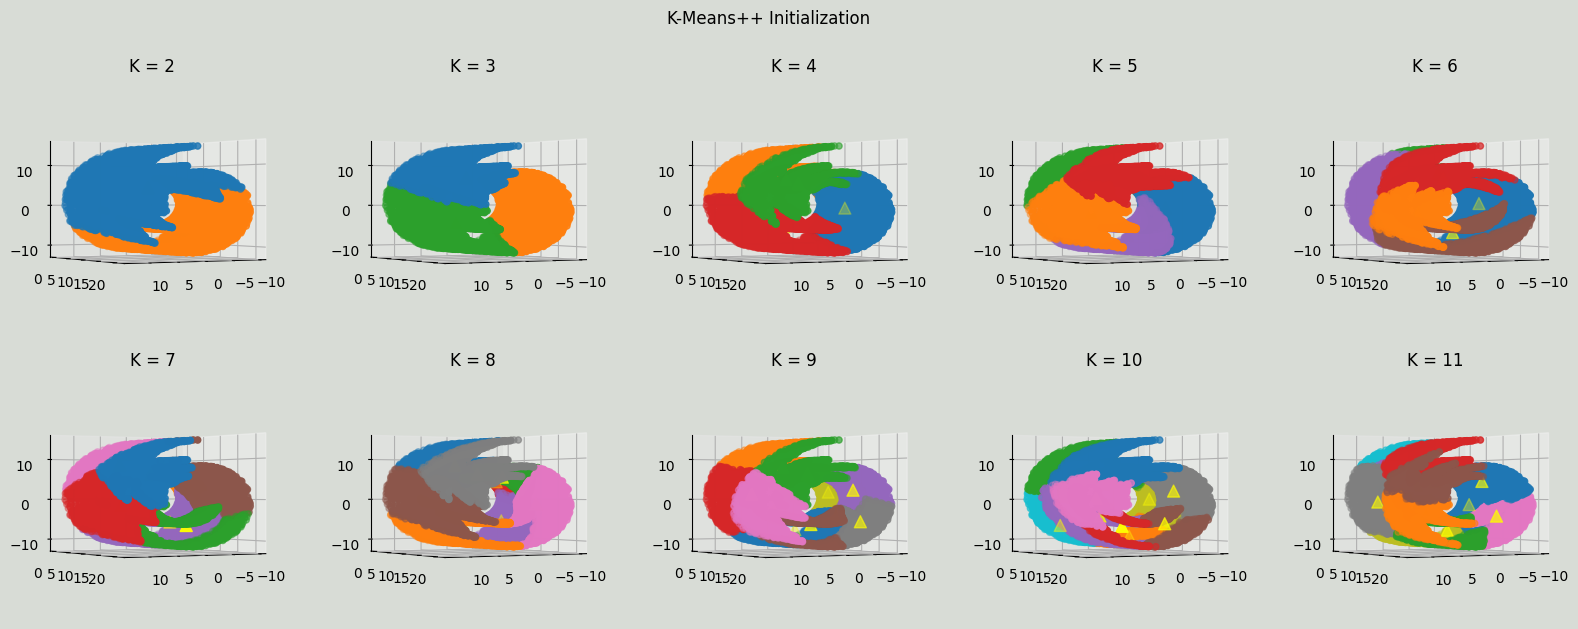

In [14]:
fig = plt.figure(figsize=(20,7))
fig.set_facecolor('xkcd:light grey')

for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i, projection='3d')
    ax.set_facecolor('xkcd:light grey')
    title = 'K = ' + str(i + 1)
    ax.title.set_text(title)
    for center in k_plus_plus_clusters_list_3d[i-1]:
        point_set_x_3D = []
        point_set_y_3D = []
        point_set_z_3D = []
        for point in k_plus_plus_clusters_list_3d[i-1][center]:
            point_set_x_3D.append(dataset2[point][0])
            point_set_y_3D.append(dataset2[point][1])
            point_set_z_3D.append(dataset2[point][2])
        ax.scatter(point_set_x_3D, point_set_y_3D, point_set_z_3D)
    ax.scatter(k_plus_plus_centers_list_3d[i-1].T[0], k_plus_plus_centers_list_3d[i-1].T[1], k_plus_plus_centers_list_3d[i-1].T[2], marker='^', s=75, color='xkcd:bright yellow')
    ax.view_init(0, 60)
plt.suptitle('K-Means++ Initialization')
plt.show()

## Hierarchical agglomerative clustering

In [15]:
# Normalization
scaler = MinMaxScaler()
dataset1_scaled = scaler.fit_transform(dataset1)
dataset2_scaled = scaler.fit_transform(dataset2)

### Dataset 1

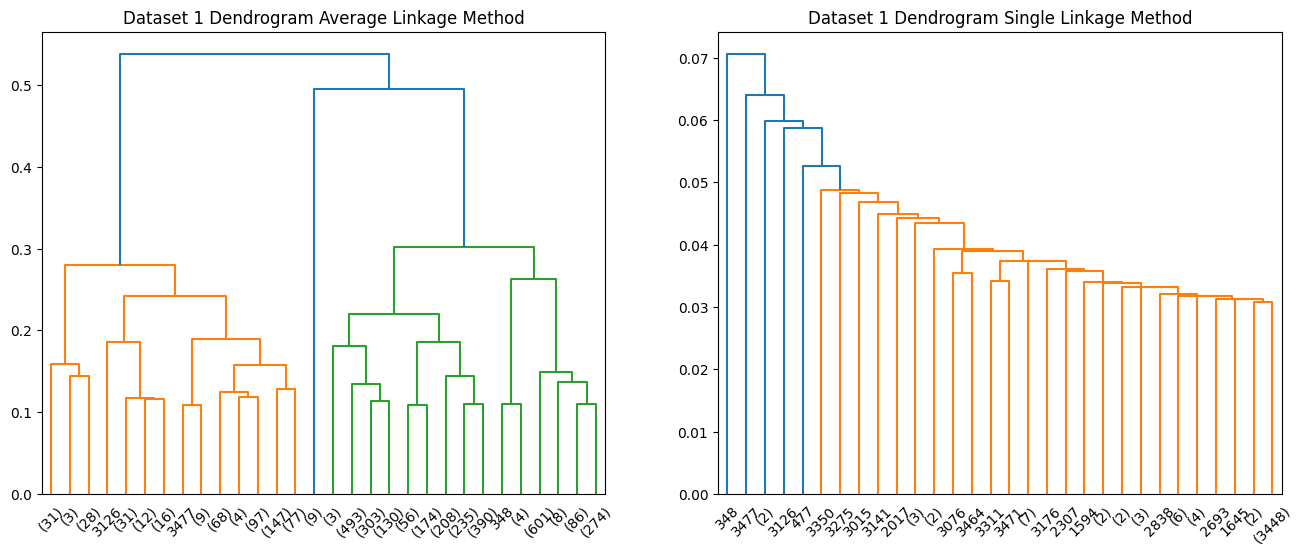

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title('Dataset 1 Dendrogram Average Linkage Method')
dataset2_dend_ward = shc.dendrogram(shc.linkage(dataset1_scaled, method='average'), truncate_mode='lastp', ax=axes[0])

axes[1].set_title('Dataset 1 Dendrogram Single Linkage Method')
dataset2_dend_single = shc.dendrogram(shc.linkage(dataset1_scaled, method='single'), truncate_mode='lastp', ax=axes[1])

plt.show()

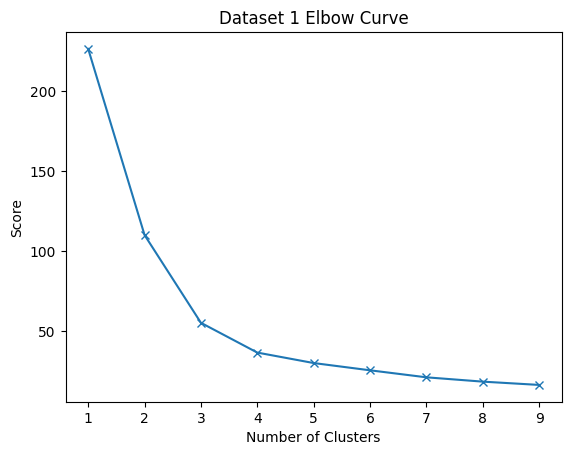

In [17]:
Nc = range(1, 10)
kmeans = [KMeans(n_init=10, n_clusters=i).fit(dataset1_scaled) for i in Nc]
score = [kmeans[i].inertia_ for i in range(len(kmeans))]
plt.plot(Nc,score, marker='x')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Dataset 1 Elbow Curve')
plt.show()

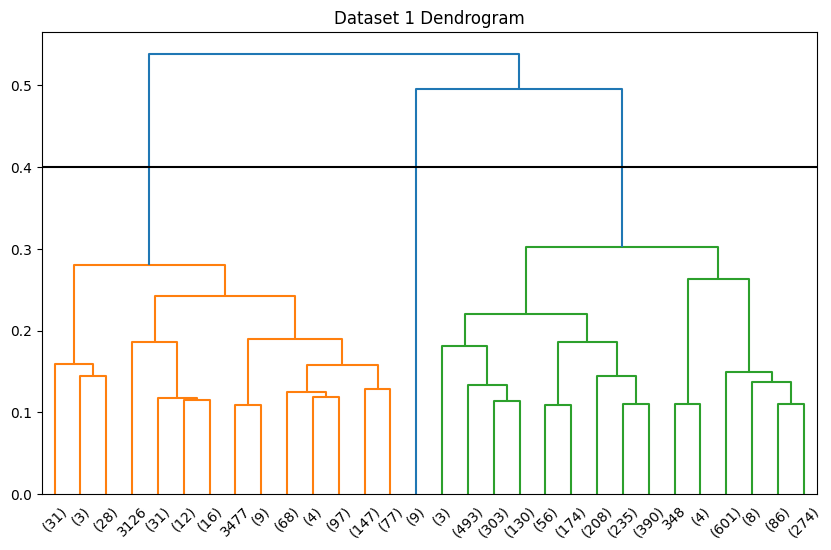

In [18]:
plt.figure(figsize=(10, 6))
plt.title('Dataset 1 Dendrogram')
dataset1_dend = shc.dendrogram(shc.linkage(dataset1_scaled, method='average'), truncate_mode='lastp')
plt.axhline(y=0.4, color = 'black')
plt.show()

### Dataset 2

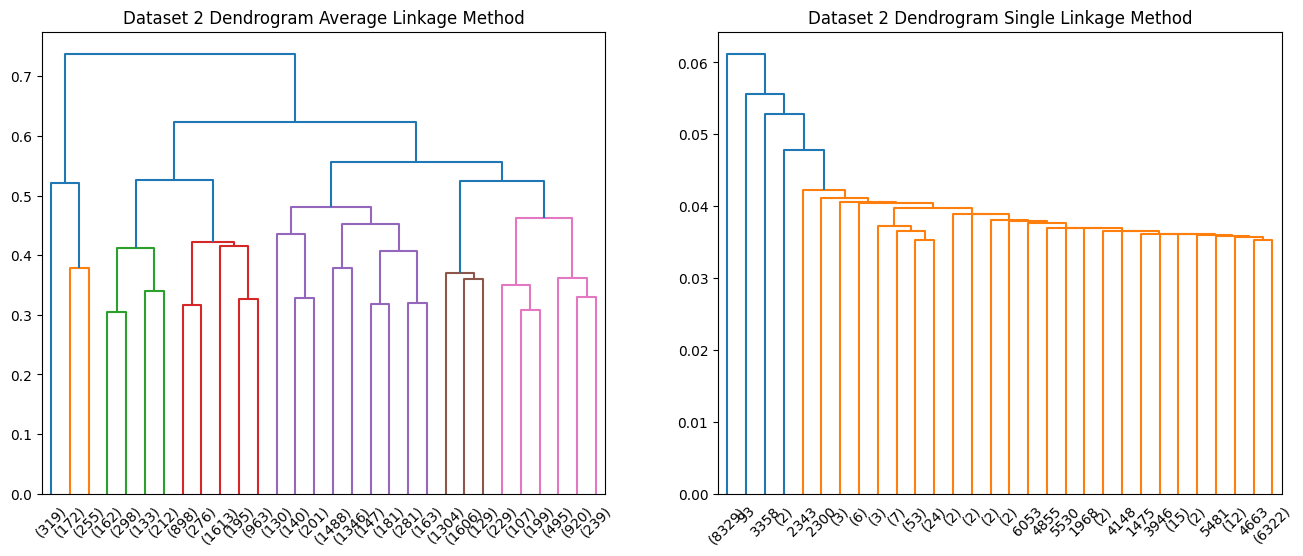

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title('Dataset 2 Dendrogram Average Linkage Method')
dataset2_dend_ward = shc.dendrogram(shc.linkage(dataset2_scaled, method='average'), truncate_mode='lastp', ax=axes[0])

axes[1].set_title('Dataset 2 Dendrogram Single Linkage Method')
dataset2_dend_single = shc.dendrogram(shc.linkage(dataset2_scaled, method='single'), truncate_mode='lastp', ax=axes[1])

plt.show()

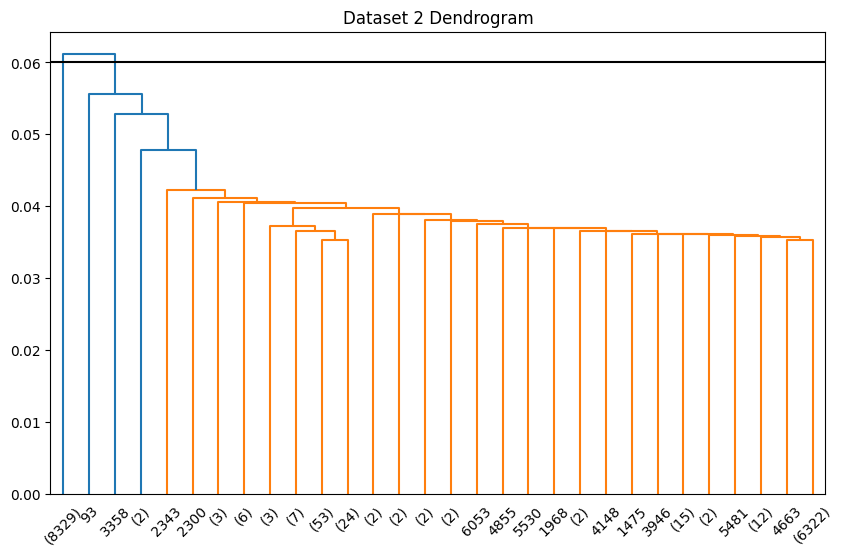

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Dataset 2 Dendrogram')
dataset2_dend = shc.dendrogram(shc.linkage(dataset2_scaled, method='single'), truncate_mode='lastp')
plt.axhline(y=0.06, color = 'black')
plt.show()